#Section 1

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
import os
import sklearn as sci
# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Using downloaded and verified file: ./dataset/train_32x32.mat
Using downloaded and verified file: ./dataset/test_32x32.mat


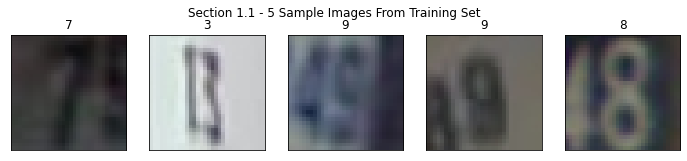

In [ ]:
# Section 1.1

def convert_to_imshow_format(image):
  image = image.numpy()
  # convert from CHW to HWC, from 3x32x32 to 32x32x3
  return image.transpose(1,2,0)

# Load Datasets
transform = transforms.Compose([transforms.ToTensor()])
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9') 
trainset = torchvision.datasets.SVHN(root='./dataset', split='train', transform=transform, target_transform=None, download=True)
testset = torchvision.datasets.SVHN(root='./dataset', split='test', transform=transform, target_transform=None, download=True)

# Make dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

# Display 5 training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))

for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

fig.suptitle('Section 1.1 - 5 Sample Images From Training Set')

plt.savefig('../output/Section 1.1 - Images From Trainset.png')


In [ ]:
# Section 1.2
# Define the CNN Architecture

class SvhnCNN(nn.Module):
    """CNN for the SVHN Datset"""

    def __init__(self):
        """CNN Builder."""
        super(SvhnCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [ ]:
# Train our model on SVHN dataset
# hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

In [ ]:
# function to calculate accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [ ]:
# function for training a model on the SVHN dataset
def TrainModel(model, model_number):
  for epoch in range(1, epochs + 1):
      model.train()  # put in training mode
      running_loss = 0.0
      epoch_time = time.time()
      for i, data in enumerate(trainloader, 0):
          # get the inputs
          inputs, labels = data
          # send them to device
          inputs = inputs.to(device)
          labels = labels.to(device)

          # forward + backward + optimize
          outputs = model(inputs)  # forward pass
          loss = criterion(outputs, labels)  # calculate the loss
          # always the same 3 steps
          optimizer.zero_grad()  # zero the parameter gradients
          loss.backward()  # backpropagation
          optimizer.step()  # update parameters

          # print statistics
          running_loss += loss.data.item()

      # Normalizing the loss by the total number of train batches
      running_loss /= len(trainloader)

      # Calculate training/test set accuracy of the existing model
      train_accuracy, _ = calculate_accuracy(model, trainloader, device)
      test_accuracy, _ = calculate_accuracy(model, testloader, device)

      log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)
      
      # save model
      if epoch % 20 == 0:
          print('==> Saving model ...')
          state = {
              'net': model.state_dict(),
              'epoch': epoch,
          }
          if not os.path.isdir('checkpoints'):
              os.mkdir('checkpoints')
          torch.save(state, f'./checkpoints/svhn{model_number}_cnn_ckpt.pth')

  print('==> Finished Training ...')

Epoch: 1 | Loss: 0.7763 | Training accuracy: 89.550% | Test accuracy: 87.873% | Epoch Time: 60.48 secs
Epoch: 2 | Loss: 0.2989 | Training accuracy: 93.351% | Test accuracy: 90.800% | Epoch Time: 60.80 secs
Epoch: 3 | Loss: 0.2263 | Training accuracy: 95.134% | Test accuracy: 92.586% | Epoch Time: 60.51 secs
Epoch: 4 | Loss: 0.1842 | Training accuracy: 96.295% | Test accuracy: 93.009% | Epoch Time: 60.43 secs
Epoch: 5 | Loss: 0.1521 | Training accuracy: 97.249% | Test accuracy: 93.627% | Epoch Time: 60.53 secs
Epoch: 6 | Loss: 0.1227 | Training accuracy: 97.858% | Test accuracy: 93.980% | Epoch Time: 60.56 secs
Epoch: 7 | Loss: 0.1012 | Training accuracy: 98.404% | Test accuracy: 93.934% | Epoch Time: 60.49 secs
Epoch: 8 | Loss: 0.0788 | Training accuracy: 98.759% | Test accuracy: 93.523% | Epoch Time: 60.60 secs
Epoch: 9 | Loss: 0.0625 | Training accuracy: 99.241% | Test accuracy: 93.873% | Epoch Time: 60.65 secs
Epoch: 10 | Loss: 0.0496 | Training accuracy: 99.429% | Test accuracy: 93

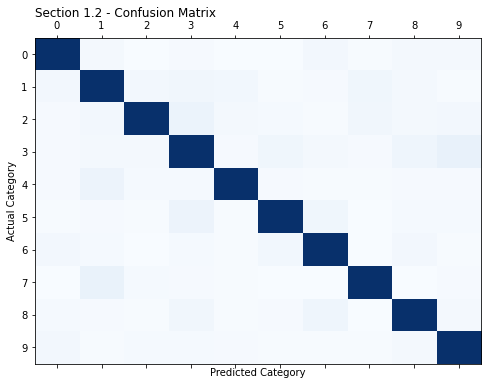

In [ ]:
# Load model from tutorial 3-4, calculate accuracy and confusion matrix
model = SvhnCNN().to(device) # no need for parameters as we alredy defined them in the class
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
TrainModel(model, 1)

# load model, calculate accuracy and confusion matrix
state = torch.load('./checkpoints/svhn1_cnn_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])
test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.title('Section 1.2 - Confusion Matrix\n', loc='left')
plt.savefig('../output/Section 1.2 - Confusion Matrix.png')
plt.show()


In [ ]:
# Section 1.3
# Design the CNN architecture
class OurSvhnCNN(nn.Module):
    """CNN for the SVHN Datset"""

    def __init__(self):
        """CNN Builder."""
        super(OurSvhnCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
        )


        self.fc_layer = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [ ]:
# Calculate the output size of the convolutional layers, before the FC layers
dummy_input = torch.zeros([1, 3, 32, 32])
dummy_model = OurSvhnCNN()
dummy_output = dummy_model.conv_layer(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)

# calculate the number of trainable weights
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)

torch.Size([1, 256, 4, 4])
torch.Size([1, 4096])
num trainable weights:  5298634


In [ ]:
# Calculate the output size of the network
dummy_input = torch.zeros([1, 3, 32, 32])
dummy_model = OurSvhnCNN()
dummy_output = dummy_model(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)

torch.Size([1, 10])
torch.Size([1, 10])


OurSvhnCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.3, inplace=False)
    (14): Conv

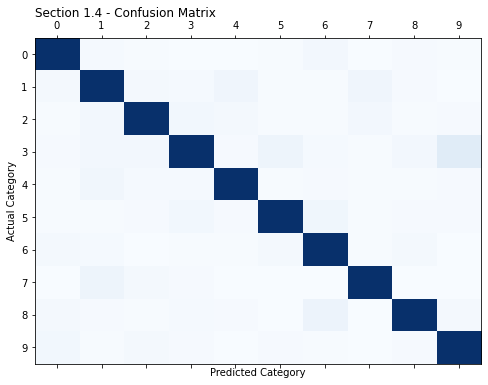

In [ ]:
# Section 1.4
model2 = OurSvhnCNN().to(device) # no need for parameters as we alredy defined them in the class
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

# display the model's architecture
print(model2)

# hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 40

# train our model
TrainModel(model2, 2)

# load model, calculate accuracy and confusion matrix
state = torch.load('./checkpoints/svhn2_cnn_ckpt.pth', map_location=device)
model2.load_state_dict(state['net'])
test_accuracy, confusion_matrix = calculate_accuracy(model2, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.title('Section 1.4 - Confusion Matrix\n', loc='left')
plt.savefig('../output/Section 1.4 - Confusion Matrix.png')
plt.show()

#Section 2

In [ ]:
# Section 2.1
# Load ImageNet class dictionary
with open("../data/my_data/ImageNet_classes.txt") as f:
    classes = eval(f.read())

# download and load the pre-trained model
model = torchvision.models.vgg16(pretrained=True, progress=True)
# put in inference mode
model.eval();

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


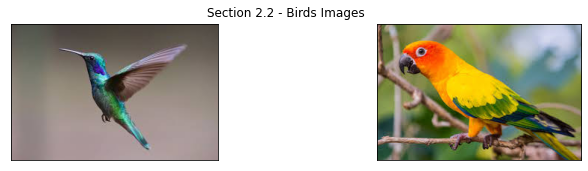

In [ ]:
# Section 2.2
# load all images
dataset = torchvision.datasets.ImageFolder('../data')

# display images
fig, axes = plt.subplots(1, 2, figsize=(12,2.5))
fig.suptitle('Section 2.2 - Birds Images')
for i in range(2):
  axes[i].imshow(plt.imread(f'../data/birds/bird_{i}.jpg'))
  axes[i].set_xticks([])
  axes[i].set_yticks([])
plt.savefig('../output/Section 2.2 - Birds Images.png')

In [ ]:
# Section 2.3
# define the pre-processing steps
# image->tensor, normalization and resize
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize(size=(224, 224)),
])

In [ ]:
# Section 2.4
# load images
bird0 = Image.open("../data/birds/bird_0.jpg")
bird1 = Image.open("../data/birds/bird_1.jpg")

# perform pre-processing
input_tensor0 = preprocess(bird0)
input_batch0 = input_tensor0.unsqueeze(0) # create a mini-batch of size 1 as expected by the model
input_tensor1 = preprocess(bird1)
input_batch1 = input_tensor1.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

input_batch = [input_batch0, input_batch1]

model = model.to(device)

for i, batch in enumerate(input_batch):
  # send to device
  batch = batch.to(device)
  # forward pass
  with torch.no_grad():
      output = model(batch)
  output_predictions = output.argmax().item()
  print(f"The output shape of image number {i+1} is: {output.shape}")
  print(f"The output prediction for image number {i+1} is: {output_predictions}")
  print(f"The matching class is: {classes[output_predictions]}\n")

The output shape of image number 1 is: torch.Size([1, 1000])
The output prediction for image number 1 is: 94
The matching class is: hummingbird

The output shape of image number 2 is: torch.Size([1, 1000])
The output prediction for image number 2 is: 90
The matching class is: lorikeet



The output shape is: torch.Size([1, 1000])
The output prediction is: 281
The matching class is: tabby, tabby cat



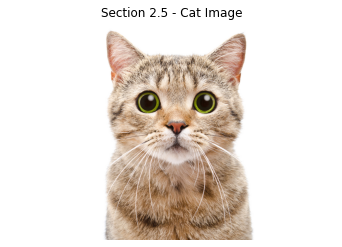

In [ ]:
# Section 2.5
# Evaluation for a new Image (cat)
fig = plt.figure()
plt.title('Section 2.5 - Cat Image')
plt.imshow(plt.imread('../data/my_data/cat_for_vgg.jpg'))
plt.axis('off')
plt.savefig('../output/Section 2.5 - Cat Image.png')

# perform pre-processing
cat = Image.open("../data/my_data/cat_for_vgg.jpg")
input_tensor0 = preprocess(cat)
input_batch0 = input_tensor0.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

input_batch = [input_batch0]

model = model.to(device)

for i, batch in enumerate(input_batch):
  # send to device
  batch = batch.to(device)
  # forward pass
  with torch.no_grad():
      output = model(batch)
  output_predictions = output.argmax().item()
  print(f"The output shape is: {output.shape}")
  print(f"The output prediction is: {output_predictions}")
  print(f"The matching class is: {classes[output_predictions]}\n")

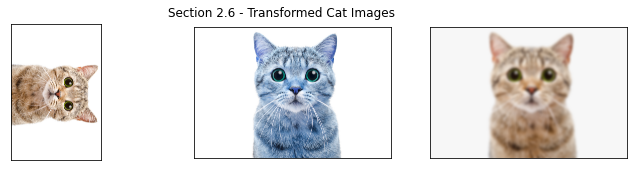

In [ ]:
# Section 2.6
cat_array = np.array(cat)
rotated_cat = cv2.rotate(cat_array, cv2.ROTATE_90_CLOCKWISE)
colored_cat = cv2.cvtColor(cat_array,cv2.COLOR_RGB2BGR)
filtered_cat = cv2.GaussianBlur(cat_array, (171,171), 0)

images = [rotated_cat, colored_cat, filtered_cat]
fig, axes = plt.subplots(1, 3, figsize=(12,2.5))
fig.suptitle('Section 2.6 - Transformed Cat Images')
for i, image in enumerate(images):
  axes[i].imshow(image)
  axes[i].set_xticks([])
  axes[i].set_yticks([])
plt.savefig('../output/Section 2.6 - Transformed Cat Images.png')

In [ ]:
# Section 2.7
def feedTheModel(model, image, title):
  input_tensor0 = preprocess(image)
  input_batch0 = input_tensor0.unsqueeze(0) # create a mini-batch of size 1 as expected by the model
  model = model.to(device)
  # send to device
  input_batch0 = input_batch0.to(device)
  # forward pass
  with torch.no_grad():
      output = model(input_batch0)
  output_predictions = output.argmax().item()
  print(f"Model prediction for the {title} cat ->", output_predictions)
  print(f"The class is: {classes[output_predictions]}\n")

feedTheModel(model, rotated_cat, 'rotated')
feedTheModel(model, colored_cat, 'colored')
feedTheModel(model, filtered_cat, 'filtered')

Model prediction for the rotated cat -> 281
The class is: tabby, tabby cat

Model prediction for the colored cat -> 285
The class is: Egyptian cat

Model prediction for the filtered cat -> 285
The class is: Egyptian cat



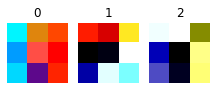

In [ ]:
# Section 2.8
# functions to visualize the kernels
def plot_filters_multi_channel(t, number_of_filters=3):
    
    # get the number of kernals
    num_kernels = t.shape[0]    
    
    # define number of columns for subplots
    num_cols = 12
    # rows = num of kernels
    num_rows = num_kernels
    
    # set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    #fig.suptitle('Section 2.8 - Filter Plots')
    
    # looping through all the kernels
    for i in range(number_of_filters):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        # for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        # standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
       
    plt.tight_layout()
    plt.savefig("../output/Section 2.8 - Filter Plots.png") 
    
    
def plot_weights(model, layer_num, collated=False, number_of_filters=3):
    # extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
    # checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        # getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data
        if weight_tensor.shape[1] == 3:
            plot_filters_multi_channel(weight_tensor)
        else:
            print("Can only plot weights with three channels with single channel = False")
    else:
        print("Can only visualize layers which are convolutional")

plot_weights(model.to('cpu'), 0)

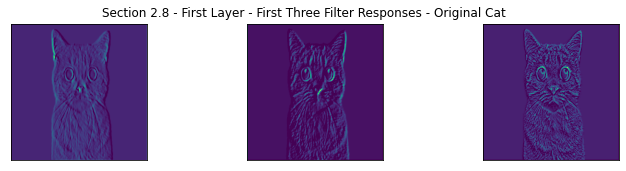

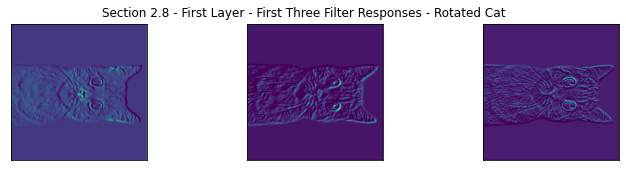

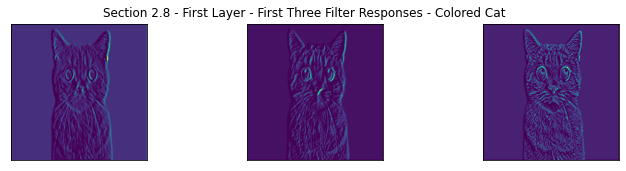

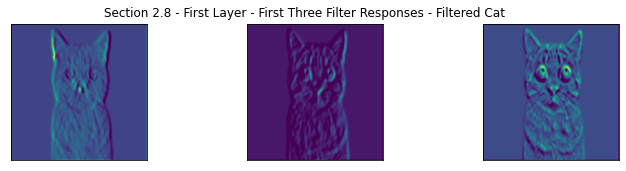

In [ ]:
def normalize(image, device=torch.device("cpu")):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = preprocess(image).unsqueeze(0).to(device)
    return image

def filter_outputs(image, model, layer_to_visualize, filters_to_print, title):
    modulelist = list(model.features.modules())
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])

    fig, axes = plt.subplots(1, 3, figsize=(12,2.5))
    fig.suptitle(title)
    for i, image in enumerate(images):
      axes[i].imshow(filters[i])
      axes[i].set_xticks([])
      axes[i].set_yticks([])
    plt.savefig(f"../output/{title}.png") 

filter_outputs(normalize(cat, 'cpu'), model, 0, 3, 'Section 2.8 - First Layer - First Three Filter Responses - Original Cat')
filter_outputs(normalize(Image.fromarray(rotated_cat.astype('uint8'), 'RGB'), 'cpu'), model, 0, 3, 'Section 2.8 - First Layer - First Three Filter Responses - Rotated Cat')
filter_outputs(normalize(Image.fromarray(colored_cat.astype('uint8'), 'RGB'), 'cpu'), model, 0, 3, 'Section 2.8 - First Layer - First Three Filter Responses - Colored Cat')
filter_outputs(normalize(Image.fromarray(filtered_cat.astype('uint8'), 'RGB'), 'cpu'), model, 0, 3, 'Section 2.8 - First Layer - First Three Filter Responses - Filtered Cat')

In [ ]:
# Section 2.9
model = torchvision.models.vgg16(pretrained=True, progress=True)
new_classifier = nn.Sequential(*list(model.classifier.children())[:-3])
model3 = model
model3.classifier = new_classifier
model3.eval()
model3 = model3.to(device)
print(model3.classifier)
# send to device
batch = []
for i in range(10):
  batch.append(preprocess(Image.open(f"../data/cats/cat_{i}.jpg")).unsqueeze(0))

for i in range(10):
  batch.append(preprocess(Image.open(f"../data/dogs/dog_{i}.jpg")).unsqueeze(0))
batch = torch.stack(batch, 0)

all_outputs = torch.zeros((20,4096))
for i, image in enumerate(batch):
  # send to device
  image = image.to(device)
  # forward pass
  with torch.no_grad():
      output = model3(image)
      all_outputs[i,:] = output

# save the feature vectors tensor
torch.save(all_outputs, "../output/Section 2.9 - Feature Vector Tensor.pt")

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)


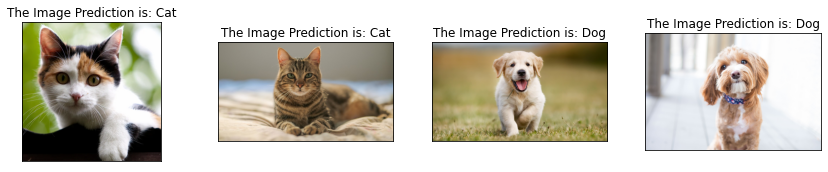

In [ ]:
# Section 2.10
import sklearn.svm as svm
classifier = svm.LinearSVC()

# Train the SVM
# The first 10 inputs are cats and their lable considered as '0' the rest are dogs and their lable considered as '1'
y = 10*[0] + 10*[1]

# load the tensor from the previous section
features = torch.load("../output/Section 2.9 - Feature Vector Tensor.pt")
classifier.fit(features, y)

fig, ax = plt.subplots(1, 4, figsize=(12,2.5))

outputs = []
for i in range (4):
  image = Image.open(f"../data/my_data/{i+1}.jpg")
  proccessed_image = preprocess(image).unsqueeze(0).to(device)
  # forward pass
  with torch.no_grad():
    output = model3(proccessed_image)
    ax[i].imshow(image)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    prediction = 'Cat' if classifier.predict(output.to('cpu')) == 0 else 'Dog'
    ax[i].set_title(f"The Image Prediction is: {prediction}")
plt.tight_layout()
plt.savefig("../output/Section 2.10 - Image Predictions.png")